In [113]:
import pysam
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from os import path
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def get_coverage(bam_path):
    with pysam.AlignmentFile(bam_path, 'rb') as alignment:
        assert(alignment.check_index())
        n_ref = len(alignment.references)
        coverages = []
        ref_lens = []
        for ref in alignment.references:
            ref_len = alignment.get_reference_length(alignment.references[0])
            curr_coverage = np.zeros(ref_len)
            positions = []
            for read in tqdm_notebook(alignment.fetch(ref)):
                curr_coverage[read.reference_start:read.reference_end] +=1
            coverages.append(curr_coverage)
        return coverages[0] if n_ref == 1 else coverages
    
def coverage_plot(coverage, bin_width=200, lab_step=4, k=1000):
    from math import ceil
    ref_len = len(coverage)
    cov_percent = len(coverage == 0)/ref_len*100
    mean_cov = round(np.mean(coverage), 3)
    l = ceil(ref_len/bin_width)
    to_plot = np.zeros(shape = l)
    labels = np.chararray(l, itemsize=11)
    rng = range(0, ref_len, bin_width)
    for i, j in enumerate(rng):
        to_plot[i] = np.mean(coverage[j:j+bin_width])
        labels[i] = f'{j//k}k-{(j+bin_width-1)//k}k'
    fig, ax = plt.subplots(figsize = [16, 9])
    ax.plot(rng, to_plot, 
            label=f'Mean coverage = {mean_cov}\nCoverage % = {cov_percent}\nBinsize = {bin_width}')
    ax.grid()
    ax.set_xlabel('Reference bp')
    ax.set_ylabel('Coverage')
    ax.set_title('Coverage plot')
    
    def decoder(x):
        return map(lambda el: el.decode(), x)

    ax.set_xticks(rng[::lab_step])
    ax.set_xticklabels(decoder(labels[::lab_step]))
    ax.legend()
    
def get_mean_error(bam_path):
    errs = []
    with pysam.AlignmentFile(bam_path, 'rb') as alf:
        for read in alf.fetch():
            curr = read.get_tag('NM')
            curr /= read.query_length
            errs.append(curr)
    return np.mean(errs)*100
    
def indel_stat(bam_path):
    indel_lens = []
    with pysam.AlignmentFile(bam_path, 'rb') as alf:
        for read in alf.fetch():
            for reg in read.cigartuples:
                if (reg[0] == 1) or (reg[0] == 2):
                    indel_lens.append(reg[1])
    return indel_lens

def indel_stat_plot(indel_lens):
    fig, ax = plt.subplots(figsize=[16, 9])
    sns.countplot(indel_lens)
    ax.set_xlabel('Indel length')
    ax.set_ylabel('Number of reads')
    ax.set_title('Indel length plot')
    ax.legend()
    ax.set_yscale('log')

def get_hpoly(ref_path):
    with pysam.FastaFile(ref_path) as ref:
        pass 
    
def get_hpoly(seq, min_len=3):
    hpolys = []
    prev = None
    curr_len = 1
    for i, char in enumerate(seq):
        if char == prev:
            curr_len += 1
        elif curr_len >= min_len:
            hpolys.append((i-curr_len, i))
            curr_len = 1
        else:
            curr_len = 1
        prev = char
    if curr_len >= min_len:
        hpolys.append((i-curr_len+1, i+1))
    return hpolys
    
def indel_stat_hpoly(bam_path, homop):
    pass

def qual_stat(bam_path, ref_path):
    in_qual = []
    mismatch_qual = []
    with pysam.AlignmentFile(bam_path, 'rb') as alignment, pysam.Fastafile(ref_path) as ref:
        for ref_contig in alignment.references:
            ref_str = ref.fetch(ref_contig)
            for read in tqdm_notebook(alignment.fetch(ref_contig)):
                start_flag = False
                for qi, ri in read.get_aligned_pairs():
                    if start_flag:
                        if (ri == None):  
                            in_qual.append(read.query_qualities[qi])
                        elif (qi != None) and (read.seq[qi].upper() != ref_str[ri].upper()):
                            mismatch_qual.append(read.query_qualities[qi])
                    elif (qi != None):
                        if (qi == read.query_alignment_start): start_flag = True 
    return in_qual, mismatch_qual

def qual_plot(in_qual, mm_qual):
    fig, axarr = plt.subplots(2, 1, figsize = [16, 18])
    sns.distplot(in_qual, kde=False, ax=axarr[0])
    axarr[0].set_title('Insertion nucleotide quality distribution')
    sns.distplot(mm_qual, kde=False, ax=axarr[1])
    axarr[1].set_title('Mismatch nucleotide quality distribution')
    for ax in axarr:
        ax.set_xlabel('Quality')
        ax.set_ylabel('Number of reads')
        ax.grid()

def sub_indel_mat(bam_path, ref_path, alphabet=['A', 'C', 'G', 'T', '_']):
    sub_mat = pd.DataFrame(np.zeros((len(alphabet), len(alphabet))), index=alphabet, columns=alphabet)
    with pysam.AlignmentFile(bam_path, 'rb') as alignment, pysam.Fastafile(ref_path) as ref:
        for ref_contig in alignment.references:
            ref_str = ref.fetch(ref_contig)
            for read in tqdm_notebook(alignment.fetch(ref_contig)):
                start_flag = False
                for qi, ri in read.get_aligned_pairs():
                    if start_flag:
                        if (qi == None) and (ref_str[ri].upper() in alphabet):
                            sub_mat.loc['_', ref_str[ri].upper()] += 1
                        elif (ri == None) and (read.seq[qi].upper() in alphabet):  
                            sub_mat.loc[read.seq[qi], '_'] += 1
                        elif (read.seq[qi] != ref_str[ri]) and (read.seq[qi] in alphabet)\
                              and (ref_str[ri].upper() in alphabet):
                            sub_mat.loc[read.seq[qi], ref_str[ri].upper()] +=1 
                        elif (qi != None):
                            if (qi == read.query_alignment_start): start_flag = True 
    return sub_mat

## Alignments obtained from IonTorrent sequencing:

In [3]:
bam_path1 = 'Data/Assignment_2/IonT/b22al_s.bam'
bam_path2 = 'Data/Assignment_2/IonT/c24al_s.bam'
ref_path = 'Data/Assignment_2/IonT/DH10B-K12.fasta'

### Dataset #1:

98.41% reads have mapped:

In [33]:
!samtools flagstat Data/Assignment_2/IonT/b22al_s.bam

497384 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
2463 + 0 supplementary
0 + 0 duplicates
489459 + 0 mapped (98.41% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [31]:
cov1 = get_coverage(bam_path1)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

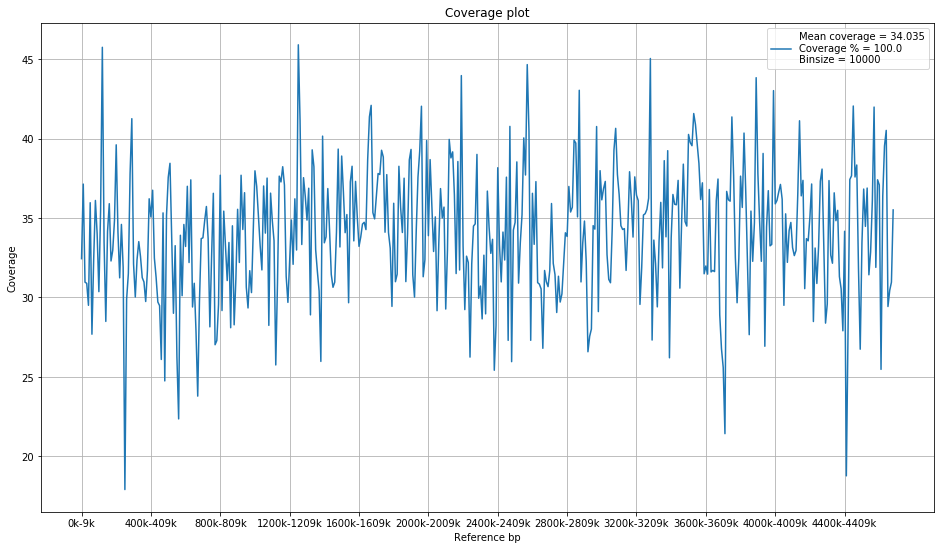

In [32]:
coverage_plot(cov1, bin_width=10000, lab_step=40)

Mean error percentage:

In [6]:
print(round(get_mean_error(bam_path1), 3), '%')

0.744 %


Indel lengths distribution:

No handles with labels found to put in legend.


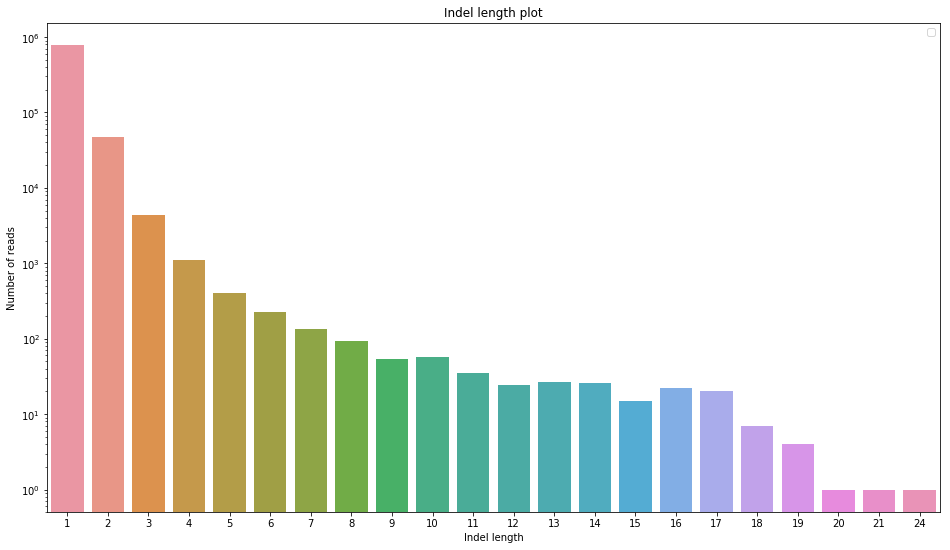

In [114]:
istat1 = indel_stat(bam_path1)
indel_stat_plot(istat1)

In [108]:
inq1, mmq1 = qual_stat(bam_path1, ref_path)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

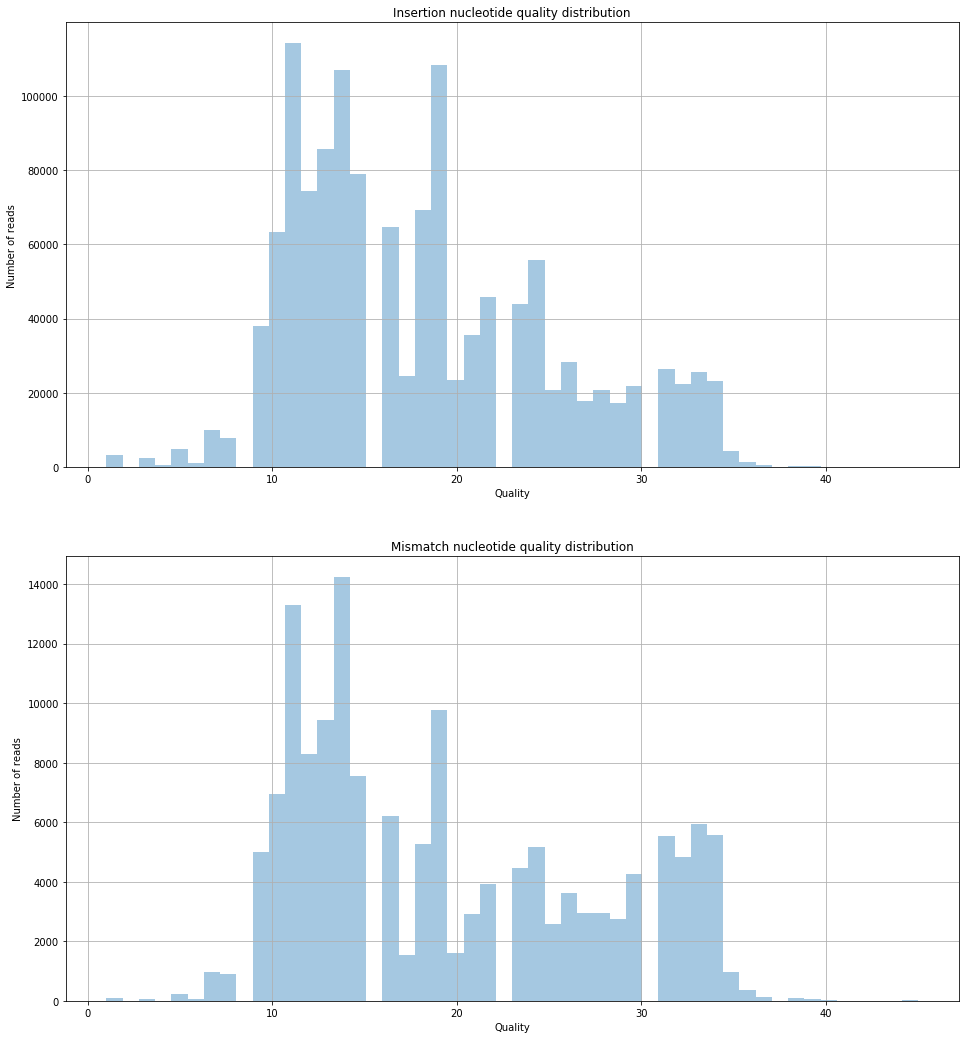

In [118]:
qual_plot(inq1, mmq1)

In [28]:
sindmat1 = sub_indel_mat(bam_path1, ref_path)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [29]:
sindmat1

,A,C,G,T,_
A,0.0,10360.0,17215.0,11325.0,404174.0
C,9147.0,0.0,7209.0,24493.0,262284.0
G,23657.0,8092.0,0.0,9060.0,258156.0
T,11173.0,16671.0,10563.0,0.0,369495.0
_,119254.0,72479.0,72804.0,119372.0,0.0


### Dataset #2:

99.41% of reads have aligned:

In [119]:
!samtools flagstat Data/Assignment_2/IonT/c24al_s.bam

686667 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
1261 + 0 supplementary
0 + 0 duplicates
682638 + 0 mapped (99.41% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

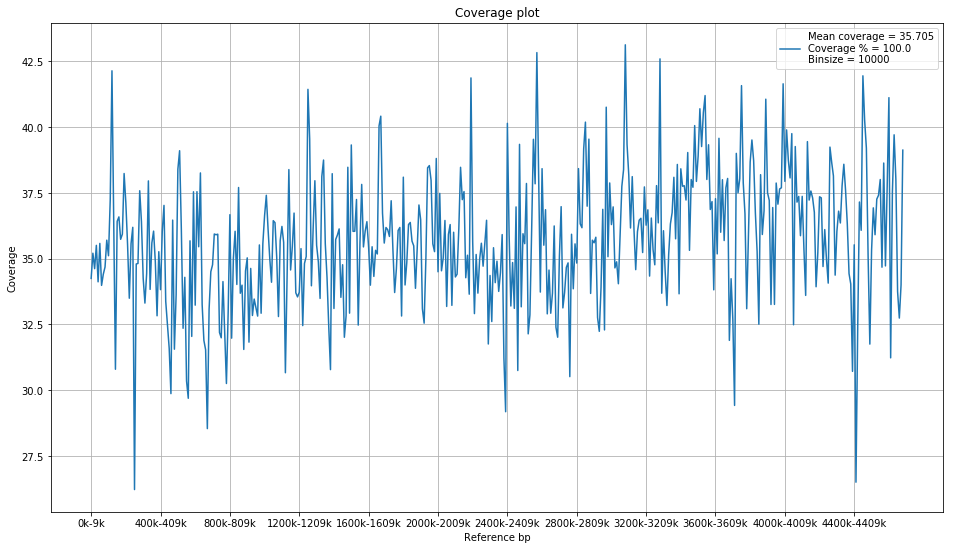

In [120]:
cov2 = get_coverage(bam_path2)
coverage_plot(cov2, bin_width=10000, lab_step=40)

In [121]:
print('Mean error percentage =', round(get_mean_error(bam_path2), 3), '%')

Mean error percentage = 0.41 %


No handles with labels found to put in legend.


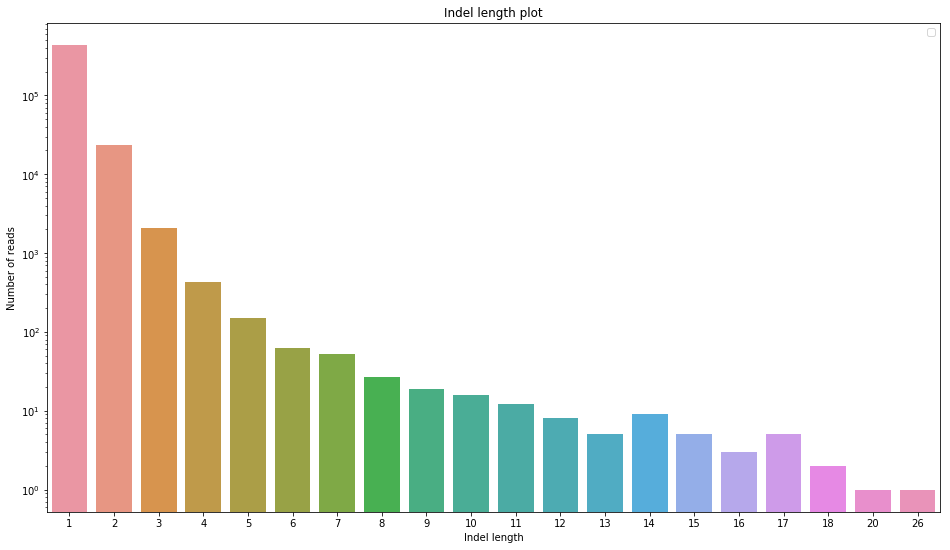

In [122]:
istat2 = indel_stat(bam_path2)
indel_stat_plot(istat2)

In [123]:
inq2, mmq2 = qual_stat(bam_path2, ref_path)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

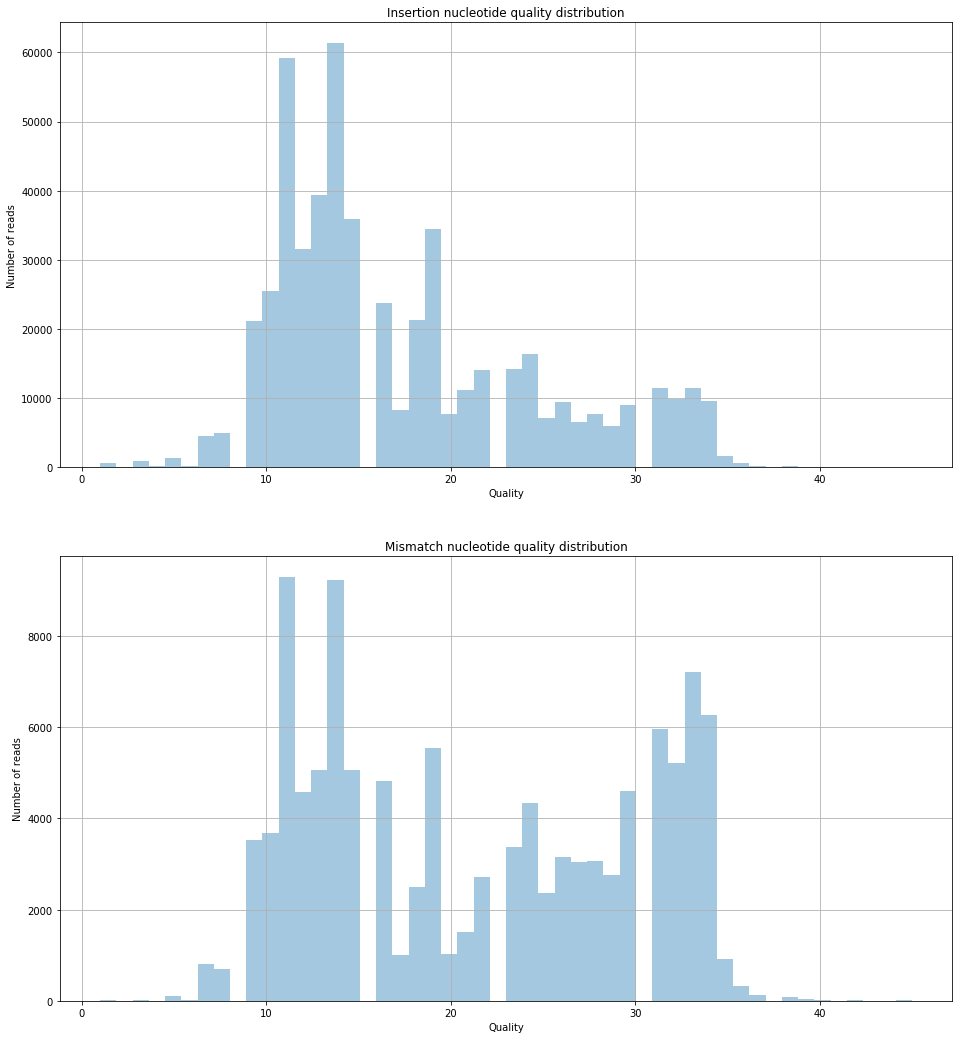

In [124]:
qual_plot(inq2, mmq2)

In [ ]:
sindmat2 = sub_indel_mat(bam_path2, ref_path)

In [ ]:
sindmat2